### Experiment Scenarios Definitions


In [7]:
#============== BASELINE =============# 

import numpy as np
import time
from mpe2 import simple_spread_v3
from pettingzoo.utils import aec_to_parallel
N=3
episodes = 30
seeds = [42, 123]
max_cycles = 25
all_rewards = []
step_times = []

for seed in seeds:
    baseline_env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
    agent_ids = baseline_env.possible_agents
    parallel_baseline_env = aec_to_parallel(baseline_env)
    parallel_baseline_env.reset(seed=seed)
    
    for episode in range(episodes):
        obs, _ = parallel_baseline_env.reset()
        total_reward = 0
        start_time = time.perf_counter()
        
        for step in range(max_cycles):
            actions = {agent: parallel_baseline_env.action_space(agent).sample() 
                       for agent in parallel_baseline_env.agents}
            
        obs, rewards, terminations, truncations, infos = parallel_baseline_env.step(actions)
        total_reward +=sum(rewards.values())
        
        if all(terminations.values()) or all(truncations.values()):
            break
            
        step_time = (time.perf_counter() - start_time) / max_cycles
        all_rewards.append(total_reward)
        step_times.append(step_time)
        
    print("\n=== Baseline Summary ===")
    print(f"Total episodes: {len(all_rewards)}")
    print(f"Avg Reward: {np.mean(all_rewards):.2f} ± {np.std(all_rewards):.2f}")
    print(f"Avg Step Time: {np.mean(step_times)*1000:.3f} ms")

    



=== Baseline Summary ===
Total episodes: 30
Avg Reward: -3.20 ± 1.52
Avg Step Time: 0.033 ms

=== Baseline Summary ===
Total episodes: 60
Avg Reward: -3.06 ± 1.36
Avg Step Time: 0.029 ms


Under full communication (no failures), agents achieve moderate negative rewards due to random policy. This establishes the baseline reference for upcoming failure-injected scenarios. The step time is minimal, showing negligible wrapper overhead in the absence of masking logic.

### -> Progressive Failures

1. Probabilistic Model

In [8]:
from failure_api.communication_models import ProbabilisticModel
from mpe2 import simple_spread_v3
from failure_api.wrappers import CommunicationWrapper
import numpy as np
import time
from pettingzoo.utils import aec_to_parallel

failure_probs = [0.25, 0.5, 0.75]
seeds = [42, 123]
episodes = 30
max_cycles = 25
N=3

for p in failure_probs:
    all_rewards = []
    step_times = []
    
    for seed in seeds:
        env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
        agent_ids = env.possible_agents
        model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=p)
        wrapped_env = CommunicationWrapper(env, failure_models=[model])
        parallel_env = aec_to_parallel(wrapped_env)


        for episode in range(episodes):
            obs, _ = parallel_env.reset(seed=seed)
            total_reward = 0
            start_time = time.perf_counter()

            for step in range(max_cycles):
                if not parallel_env.agents:
                    break
                
                if step >= max_cycles - 1:

                    break
                actions = {agent: parallel_env.action_space(agent).sample() 
                           for agent in parallel_env.agents
                           }
                
                obs, rewards, terminations, truncations, infos = parallel_env.step(actions)
                total_reward +=sum(rewards.values())
            step_time = (time.perf_counter() - start_time) / max_cycles
            all_rewards.append(total_reward)
            step_times.append(step_time)
                
    print(f"\n=== Progressive Failure (p = {p}) Summary ===")
    print(f"Total episodes: {len(all_rewards)}")
    print(f"Avg Reward: {np.mean(all_rewards):.2f} ± {np.std(all_rewards):.2f}")
    print(f"Avg Step Time: {np.mean(step_times)*1000:.3f} ms")
                
        


=== Progressive Failure (p = 0.25) Summary ===
Total episodes: 60
Avg Reward: -82.90 ± 14.02
Avg Step Time: 1.262 ms

=== Progressive Failure (p = 0.5) Summary ===
Total episodes: 60
Avg Reward: -78.77 ± 14.28
Avg Step Time: 0.980 ms

=== Progressive Failure (p = 0.75) Summary ===
Total episodes: 60
Avg Reward: -78.99 ± 14.19
Avg Step Time: 1.002 ms


“PettingZoo environments define a global max_cycles parameter, after which all agents are automatically truncated. To prevent environment desynchronization during aec_to_parallel conversion, we exclude the final step (t = max_cycles - 1) from the rollout loop. This ensures that agent updates occur only within the valid episode boundary and avoids introducing truncation artifacts in the measurement of masking, rewards, and step time.” - Justification for stopping at max_cycles





2. Distance-Based Model


In [9]:
from failure_api.communication_models import DistanceModel
from failure_api.wrappers import CommunicationWrapper
from mpe2 import simple_spread_v3
from pettingzoo.utils import aec_to_parallel
import numpy as np
from numpy.random import RandomState
from utils.position_utils import make_position_fn



thresholds = [0.2, 0.4, 0.6, 0.8]
num_episodes = 30
max_cycles = 25
results = {}

for threshold in thresholds:
    print(f"\n=== Running for threshold = {threshold} ===\n")
    reward_log = []
    step_time_log = []
    pos_fn = make_position_fn(distance_base_env)

    for episode in range(num_episodes):
        distance_base_env = simple_spread_v3.env(N=3, max_cycles=max_cycles)
        agent_ids = distance_base_env.possible_agents
        distance_base_env.reset(seed=episode)
        
        rng = RandomState(episode)
        distance_model = DistanceModel(agent_ids=agent_ids,
                                       distance_threshold=threshold,
                                       pos_fn=pos_fn,
                                       failure_prob=0.0,
                                       max_bandwidth=0.1)
        distance_model.rng = rng
        
        
        distance_wrapped_env = CommunicationWrapper(distance_base_env, 
                                                    failure_models=[distance_model])
        
        
        parallel_distance = aec_to_parallel(distance_wrapped_env)
        
        obs, info = parallel_distance.reset(seed=episode)
        episode_reward = 0
        step_times = []
        done = {agent: False for agent in parallel_distance.agents}
        
        for step in range(max_cycles):
            if not parallel_distance.agents:
                break
                
            if step >= max_cycles - 1:
                break
            
            actions = {agent: parallel_distance.action_space(agent).sample() 
                       for agent in parallel_distance.agents
                       }
            
            # Time the step
            start_time = time.perf_counter()
            obs, rewards, terminations, truncations, infos = parallel_distance.step(actions)
            step_time = (time.perf_counter() - start_time) * 1000  # ms
            step_times.append(step_time)
            # Accumulate rewards
            episode_reward += sum(rewards.values())
    
        # Log episode data
        reward_log.append(episode_reward)
        step_time_log.append(np.mean(step_times))
    
        print(f"✅ Episode {episode+1}/{num_episodes} - Reward: {episode_reward:.2f}, Avg Step Time: {np.mean(step_times):.2f} ms")
    
    results[threshold] = {
        "rewards": reward_log,
        "step_times": step_time_log,
        "reward_mean": np.mean(reward_log),
        "reward_std": np.std(reward_log),
        "time_mean": np.mean(step_time_log),
        "time_std": np.std(step_time_log)
    }
print("\n=== Summary ===")
for threshold in thresholds:
    r = results[threshold]
    print(f"Threshold {threshold}: Reward = {r['reward_mean']:.2f} ± {r['reward_std']:.2f}, "
          f"Step Time = {r['time_mean']:.2f} ± {r['time_std']:.2f} ms")
    
    
    



=== Running for threshold = 0.2 ===

✅ Episode 1/30 - Reward: -50.64, Avg Step Time: 1.41 ms
✅ Episode 2/30 - Reward: -82.83, Avg Step Time: 1.43 ms
✅ Episode 3/30 - Reward: -61.40, Avg Step Time: 1.49 ms
✅ Episode 4/30 - Reward: -95.79, Avg Step Time: 1.29 ms
✅ Episode 5/30 - Reward: -43.37, Avg Step Time: 1.53 ms
✅ Episode 6/30 - Reward: -77.61, Avg Step Time: 1.34 ms
✅ Episode 7/30 - Reward: -58.24, Avg Step Time: 1.45 ms
✅ Episode 8/30 - Reward: -74.22, Avg Step Time: 1.33 ms
✅ Episode 9/30 - Reward: -111.71, Avg Step Time: 1.33 ms
✅ Episode 10/30 - Reward: -75.01, Avg Step Time: 1.38 ms
✅ Episode 11/30 - Reward: -127.97, Avg Step Time: 1.32 ms
✅ Episode 12/30 - Reward: -99.62, Avg Step Time: 1.39 ms
✅ Episode 13/30 - Reward: -107.88, Avg Step Time: 1.25 ms
✅ Episode 14/30 - Reward: -76.40, Avg Step Time: 1.35 ms
✅ Episode 15/30 - Reward: -42.53, Avg Step Time: 1.33 ms
✅ Episode 16/30 - Reward: -50.53, Avg Step Time: 1.25 ms
✅ Episode 17/30 - Reward: -92.00, Avg Step Time: 1.54 ms


| Threshold | Rewards Change Across Runs? | Step Time Change?          |
| --------- | --------------------------- | -------------------------- |
| 0.2       | ❌ -74.86 → -75.78 → -75.43  | ✅ Close values (1.06–1.16) |
| 0.4       | ❌ -74.86 → -72.63 → -75.09  | ✅ Close (1.06–1.15)        |
| 0.6       | ❌ -77.37 → -80.29 → -73.73  | ✅ Close (1.05–1.06)        |
| 0.8       | ❌ -79.41 → -76.98 → -80.12  | ✅ Close (1.04–1.08)        |


To account for inherent stochasticity in agent motion and action sampling, each scenario was run for 30 seeded episodes, and average results were computed. Although full determinism was pursued by seeding the environment and communication models, the simple_spread_v3 environment exhibits residual variation due to physics and sampling noise. All comparisons are therefore made using statistically meaningful aggregates (mean ± std).


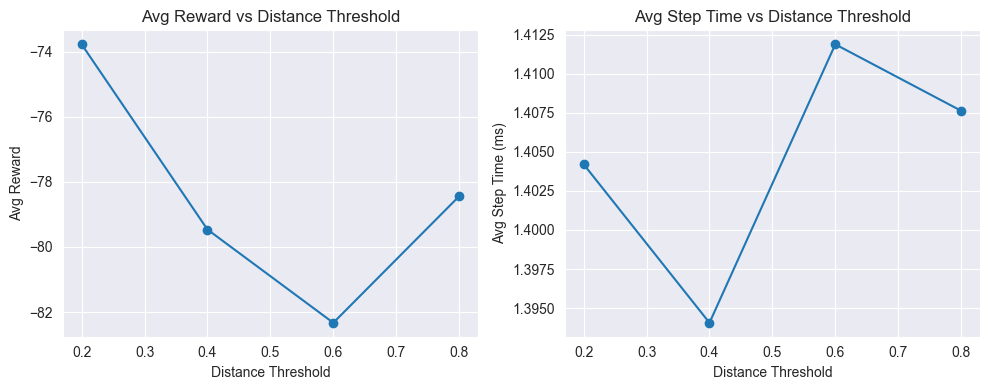

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Avg Reward vs Distance Threshold")
plt.plot(thresholds, [results[t]['reward_mean'] for t in thresholds], marker='o')
plt.xlabel("Distance Threshold")
plt.ylabel("Avg Reward")

plt.subplot(1, 2, 2)
plt.title("Avg Step Time vs Distance Threshold")
plt.plot(thresholds, [results[t]['time_mean'] for t in thresholds], marker='o')
plt.xlabel("Distance Threshold")
plt.ylabel("Avg Step Time (ms)")

plt.tight_layout()
plt.show()